In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# import itertools
from tqdm.auto import tqdm

In [4]:
def show(img):
    i = img.astype('uint8')*255 if img.dtype == 'bool' else img
    # print(i.dtype, i.ndim)
    plt.figure(figsize=(10, 10))
    if img.ndim == 3:
        # color
        plt.imshow(img[..., ::-1], interpolation='none')
    else:
        plt.imshow(img, cmap='gray', interpolation='none')
        # plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
    plt.show()

## Read Image

In [5]:
# filename = 'castle'
filename = 'library_1'
# filename = '101'
type = "TIME"
# type = "EV"

folder = "data/"+filename

In [6]:
file_names = os.listdir(folder)
imgs = [(cv2.imread(folder + "/" + f), np.float32(f.rsplit(".", 1)[0])) for f in file_names]
imgs, evs = zip(*imgs)

# resize
if imgs[0].shape[0] > 2000 or imgs[0].shape[1] > 2000:
    shape = np.array(imgs[0].shape)[:2][::-1]//4
    imgs = [cv2.resize(i, tuple(shape)) for i in imgs]

imgs = np.array(imgs)
gimgs = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in imgs]
if type == "TIME":
    # filename is dt
    dt = evs
else:
    # ev = 0 for 1 sec
    dt = 2**(-np.array(evs))

lndt = np.log(dt)
print(f"Loading {len(imgs)} images from folder \"{folder}\", dt:")
print(dt)
print("file_attr:", evs)

Loading 7 images from folder "data/library_1", dt:
(0.25, 0.5, 1.0, 15.0, 2.0, 4.0, 8.0)
file_attr: (0.25, 0.5, 1.0, 15.0, 2.0, 4.0, 8.0)


# Recovering Response Curve

In [7]:
def SolveResponseCurve(imgs, P, N, z_mid):
    print(f"Z_mid = {z_mid}, P = {P}, N = {N}")

    # pixs[P][N]
    fimgs = [f.flatten() for f in imgs]
    idx = np.random.choice(fimgs[0].shape[0], N, replace=False)
    pixs = np.array([f[idx] for f in fimgs])
    shape = (N*P+255, 256+N)

    # =====================================
    # Ax = b
    # mat A
    A = np.zeros(shape, dtype=float)
    for i in tqdm(range(0, N), leave=False):
        # left_up block
        i0 = i*P
        for p in range(P):
            A[i0+p, pixs[p, i]] = 1
        # right_up block
        A[i0:i0+P, 256+i] = -1
    # Z_mid constraint
    A[N*P, z_mid] = 1
    # left_bot block
    i0 = N*P+1-1
    A[i0:i0+254, :254] += np.eye(254)
    A[i0:i0+254, :255] += np.eye(255, k=1)[:254]*(-2)
    A[i0:i0+254, :256] += np.eye(256, k=2)[:254]
    # print(A[i0:i0+254, :256].shape)

    # vec b
    b = np.zeros(shape[0], dtype=float)
   
    b[:N*P] = np.tile(lndt, N)

    # Solve lsq
    x = np.array(np.linalg.lstsq(A, b, rcond=0.001)[0])
    # =====================================

    g = x[:256]
    e = np.exp(x[256:])
    return g, e


In [8]:
def inv_f(g, imgs):
    # print("=====================")
    # print(g.shape, g.min(), g.max())

    a = np.sum([w[imgs[p]]*(g[imgs[p]]-lndt[p]) for p in range(P)], axis=0)
    # print(a.shape, a.min(), a.max())

    b = np.sum([w[imgs[p]] for p in range(P)], axis=0)
    # print(b.shape, b.min(), b.max())
    
    res = np.exp(a/b)
    # print(res.min(), res.max())
    return res

Set parameters

In [9]:
z_mid = (0+255)//2
# N(P-1) > 255
# takes n times points
P = len(imgs)
n = 30 # sample number multiplier
N = int((255 / (P-1)) * n)
print(f"Z_mid = {z_mid}, P = {P}, N = {N}")
shape = (N*P+255, 256+N)

Z_mid = 127, P = 7, N = 1275


Main flow

In [10]:
# [ch, P, h, w]
rgb_imgs = imgs.transpose([3, 0, 1, 2])
# solve curve for each channels
rgb_g = [SolveResponseCurve(img, P, N, z_mid)[0] for img in rgb_imgs]
w = lambda z: z-0+1 if z <= z_mid else 255-z+1 # add a positive value to prevent from divided-by-zero
w = np.vectorize(w)(np.arange(256))
hdr_result = np.array([inv_f(g, imgs) for g, imgs in zip(rgb_g, rgb_imgs)])



Z_mid = 127, P = 7, N = 1275


  0%|          | 0/1275 [00:00<?, ?it/s]

Z_mid = 127, P = 7, N = 1275


  0%|          | 0/1275 [00:00<?, ?it/s]

Z_mid = 127, P = 7, N = 1275


  0%|          | 0/1275 [00:00<?, ?it/s]

## HDR Result

### Response Curve

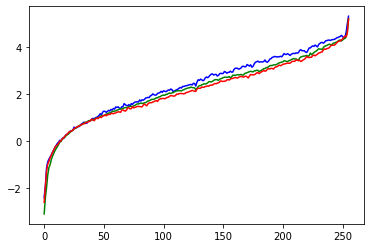

In [12]:
# sns.set_theme(style="darkgrid")
plt.clf()
color = ['blue', 'green', 'red']
for i, g in enumerate(rgb_g):
    sns.lineplot(data=g, color=color[i])

### Heat Map

# Global Tonemapping

In [9]:
def normalize(img):
    _min = img.min()
    _max = img.max()
    return (img-_min)/(_max-_min)

def luminance(idx, img):
    # weight = [0.2125, 0.7154, 0.0721]
    # img = weight[idx] * img
    return img

def globalToneMapping(idx, img):
    alpha = 0.18
    lum = luminance(idx, img)
    # img = normalize(img)*255.0
    # ep = np.finfo(float).eps
    ep = 10-5
    lbar = np.exp(np.sum(np.log(ep + lum))/(lum.shape[0] * lum.shape[1]))
    lum = alpha * np.exp(lum) / lbar
    lum = lum / (1.0 + lum)

    return lum

In [10]:
ldr_result = np.array([globalToneMapping(idx, img)*255 for idx, img in enumerate(hdr_result)]).astype('uint8')
ldr_result = ldr_result.transpose([1, 2, 0])

## Tonemapped LDR Result
One of Inputs (left), Result (Right)

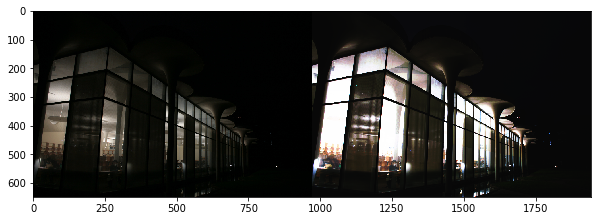

In [11]:
show(np.concatenate([imgs[1], ldr_result], axis=1))

# Save as EXR file

In [12]:
import OpenEXR as exr
import array

In [13]:
# print(*after.shape[::-1][:2])
f = exr.OutputFile(f"{folder}.exr", exr.Header(*hdr_result.shape[::-1][:2]))
exr_img = [array.array('f', normalize(i).flatten()).tostring() for i in hdr_result]
f.writePixels({
    'R':exr_img[2],
    'G':exr_img[1],
    'B':exr_img[0],
})
f.close()

<ipython-input-13-45b4c2eb6fe3>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  exr_img = [array.array('f', normalize(i).flatten()).tostring() for i in hdr_result]
